Zadanie polega na stworzeniu modelu rekurencyjnego, który będzie przewidywał kompozytora danego utworu muzyki klasycznej w oparciu o jego zapis w formie sekwencji akordów. Akordy znormalizowane zostały do klucza C-dur lub a-moll, w zależności od skali utworu (durowa/molowa).
Dane przygotowane są w postaci pickle (https://docs.python.org/3/library/pickle.html), w których znajduje się lista krotek z sekwencjami i odpowiadającymi im klasami (kompozytorami), odpowiednio: {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}. Dane treningowe znajdują się w pliku train.pkl. W pliku test_no_target.pkl znajdują się testowe sekwencje, dla których predykcje mają Państwo przewidzieć.

Uwaga, utwory mogą mieć różne długości. Do stworzenia batchy dla przykładów różnej długości proszę wykorzystać omówiony na zajęciach padding i trenować z wykorzystaniem spaddowanych tensorów lub spakowanych sekwencji (PackedSequence).

Bardzo proszę, żeby zwrócili Państwo archiwum zip, zgodnie z instrukcjami:
- Archiwum powinno być nazwane {poniedzialek/piatek}_nazwisko1_nazwisko2.zip (lub nazwa drużyny), bez nawiasów klamrowych przy dniu tygodnia
- W archiwum proszę bez zbędnych podfolderów umieścić pliki ze swoim kodem i testowe predykcje nazwane {poniedzialek/piatek}_nazwisko1_nazwisko2.csv (lub nazwa drużyny), bez nawiasów klamrowych przy dniu tygodnia
- Testowe predykcje powinny mieć kolejność zgodną z kolejnością sekwencji w picklu. Plik csv. nie powinien mieć nagłówka ani indeksów.

Proszę zwracać uwagę na prawidłowe nazewnictwo oraz odpowiedni format zwracanych plików. Niedostosowanie się do wytycznych może spowodować nieuwzględnienie Państwa w rankingu i utratę punktów za osiągnięty wynik!

In [278]:
# !pip install GPUtil
#
# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda
#
# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()
#
#     torch.cuda.empty_cache()
#
#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)
#
#     print("GPU Usage after emptying the cache")
#     gpu_usage()
#
# free_gpu_cache()
#
# import sys
# torch.cuda.empty_cache()
# sys.modules[__name__].__dict__.clear()
# !nvidia-smi

In [279]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [280]:
device = torch.device("cuda")
device

device(type='cuda')

Prepare dataset


In [281]:
import pickle

In [282]:
file = open('train.pkl', 'rb')
train = pickle.load(file)
file.close()

test_file = open('test_no_target.pkl', 'rb')
test_no_target = pickle.load(test_file)
test_file.close()

In [283]:
train

[(array([ -1.,  -1.,  -1., ...,  78.,  40., 144.]), 0),
 (array([ -1.,  -1., 144., ...,  32.,  -1.,  -1.]), 0),
 (array([ 66., 100., 148., 148., 146.,  64., 146., 148.,  82.,   0.,  82.,
         100.,  34., 132., 180.,  65.,  80.,  81., 131.,  52.,  34.,  52.,
          64.,  52.,   3.,  66., 147.,  20.,   4., 132., 132., 100., 111.,
          74., 110.,  60.,  92.,  65., 100., 189.,  44.,   8.,   5.,  76.,
          31., 159.,   5., 124.,   4.,  12.,  51., 157.,  57.,  31., 183.,
          57.,  65.,  92.,  69., 124., 122.,  79., 110.,  76.,  12.,  12.,
          12.,  12.,   8., 159.,  12., 156., 100., 111.,  52., 121.,  36.,
          47.,  41.,  41.,   8., 172.,  38.,  12.,  78.,  12.,  88.,  47.,
         119.,  20.,  47.,  12., 159.,  20.,  20.,  76.,  60., 110., 132.,
         185., 120.,  45., 110., 110.,  72., 124., 178.,  73.,   8.,  78.,
          12.,  42., 173.,  12., 150.,  84.,  66., 152.,  69.,   8.,  41.,
         159.,   5.,  78.,  44., 180.,  71.,  92., 152.,   6., 

In [284]:
test_no_target

[array([  0.,   0.,   0.,   0.,  88.,  88.,  88.,  88.,  69., 145., 145.,
        145.,   5.,   5.,   5.,   5.,  92.,  88.,  88.,  80.,  45.,  39.,
        190., 190., 124., 112., 112., 112.,  77.,  36.,  36.,  36.,  20.,
         20.,  13., 158., 127.,  55.,  55., 113., 127., 151.,  22., 116.,
        144., 144.,  34.,  68.,  33.,  33.,  33.,  41.,  41.,  47.,  47.,
        180.,  12., 119.,  37., 100., 112., 112.,   2.,  36.,   0.,   0.,
          0.,   0.,  88.,  88., 120., 120.,  12.,   5.,  13.,  13.,  92.,
        149.,  32.,   4.,  12.,  37.,  12., 159.,  13.,   6., 124.,  37.,
        124.,  37.,  37.,   8.,   8., 119.,  78.,  73.,  12.,   0.,   0.,
          0.,  88.,  88.,  88.,  88.,  69., 145., 145., 145.,   5.,   5.,
          5.,   5.,  92.,  88.,  88.,  80.,  45.,  39., 190., 190., 124.,
        112., 112., 112.,  77.,  36.,  36.,  36.,  20.,  20.,  13., 158.,
        127.,  55.,  55., 113., 127., 151.,  22., 116., 144., 144.,  34.,
         68.,  33.,  33.,  33.,  41., 

(30, 5322)
(5322,)


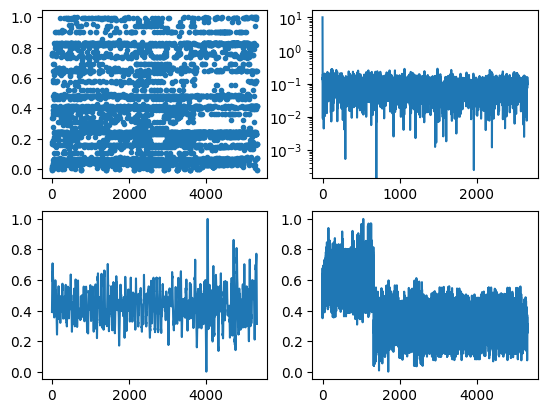

In [285]:
import pywt
from scipy.fft import fft, fftfreq
from scipy import signal

def flatten_list(l):
    return [item for sublist in l for item in sublist]
#choosen_sample = np.delete(train[200][0],[0])
choosen_sample =train[1][0] # orginal signal
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
N = len(choosen_sample)
T = 1.0 / len(choosen_sample)

ax1.plot(choosen_sample,'.')

yfreq = fft(choosen_sample) # Fourier transform
xfreq = fftfreq(N, T)[:N//2]
ax2.semilogy(xfreq, 2.0/N * np.abs(yfreq[0:N//2]))

widths = np.arange(1, 31)
wavelet = signal.ricker # only option unfortunately
#cwtmatr = signal.cwt(choosen_sample , wavelet, widths) # Continuous Wavelet Transform

cwtmatr, freqs = pywt.cwt(choosen_sample, widths, 'mexh') # Continuous Wavelet Transform # 'gaus1'
print(cwtmatr.shape)

coeffArray = pywt.wavedec(choosen_sample,'db1',level=2)  # Multilevel discrete Wavelet transform
#print(coeffArray)
ax3.imshow(cwtmatr, extent=[-1, 1, 31, 1], cmap='seismic', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

# cwtmatr_sum = cwtmatr[0][:]
# for i in range(1,len(cwtmatr)-1):
#     cwtmatr_sum += cwtmatr[i][:]
#
# ax3.plot(cwtmatr_sum)
#
# print(cwtmatr_sum.shape)
dwt_coeffs = flatten_list(coeffArray)

ax4.plot(dwt_coeffs)


plt.show()

In [33]:
train_x0 = []
train_x1 = []
train_x2 = []
train_x3 = []
train_x4 = []

for i in range(0,len(train[:])):
    if train[i][1] == 0:
        train_x0.append(train[i][0])
    elif train[i][1] == 1:
        train_x1.append(train[i][0])
    elif train[i][1] == 2:
        train_x2.append(train[i][0])
    elif train[i][1] == 3:
        train_x3.append(train[i][0])
    else:
        train_x4.append(train[i][0])



plt.hist(train_x0[:],density=True,lw=3,fc=(0, 1, 0, 0.2))
plt.show()
plt.hist(train_x1[:],density=True,lw=3,fc=(0, 1, 0, 0.2))
plt.show()
plt.hist(train_x2[:],density=True,lw=3,fc=(1, 0, 0, 0.2))
plt.show()
plt.hist(train_x3[:],density=True,lw=3,fc=(1, 1, 0, 0.2))
plt.show()
plt.hist(train_x4[:],density=True,lw=3,fc=(1, 0, 1, 0.2))
plt.show()

In [288]:
from torch import nn
from torch.nn.utils.rnn import pad_sequence

In [289]:
import random
from scipy import signal
from random import sample
import itertools
def swapNresample(list_set, std):
    sampled_list = sample(list_set, 1) # one sample
    compositor = sampled_list[0][1] # target
    sampled_list = sampled_list[0][0]
    l = int(len(sampled_list)/4)

    #print(sampled_list )
    r1_a = int(round(random.uniform(5,int(l/2)-1),0))
    r1_b = int(round(random.uniform(int(l/2),l-5),0))

    if r1_a > r1_b:
        r1_c = r1_a
        r1_a = r1_b
        r1_b = r1_c
        l_off = r1_b
    else:
        l_off = r1_a

    offset = int(round(random.uniform(2,l_off-1),0))
    r2_a = r1_a - offset
    r2_b = r1_b - offset

    if r2_a <= -1 or r2_b <= -1 or r1_a <= -1 or r1_b <= -1:
        off2 = int(round(random.uniform(25,50),0))
        r2_a +=off2
        r2_b +=off2
        r1_a +=off2
        r1_b +=off2
    #print(r1_a,r1_b,r2_a,r2_b)

    augument_select = int(random.randint(0,3))
    if augument_select == 0:
        # SWITCHING BLOCK OF CLASSICAL MUSIC BY RANGE
        sampled_list[r2_a:r2_b], sampled_list[r1_a:r1_b] = sampled_list[r1_a:r1_b], sampled_list[r2_a:r2_b]
        # CUT SONG IN RANGE
    elif augument_select == 1:
        sampled_list[r1_a:r1_b] = 0
    elif augument_select == 2:
        sampled_list[r2_a:r2_b] = 0
    else:
        # ## ADDING NOISE - probably bad idea in this type of data
        sl = signal.resample(sampled_list,len(sampled_list))
        for i in range(0,len(sl)):
           sampled_list[i] = int(round(random.uniform(sl[i]-sl[i]*std, sl[i]+sl[i]*std),0))
    return sampled_list,compositor #touple output


std = 5
#print(f)
train_c0 = []
train_c1 = []
train_c2 = []
train_c3 = []
train_c4 = []

for i in range(0,len(train[:])):
    if train[i][1] == 0:
        train_c0.append(train[i])
    elif train[i][1] == 1:
        train_c1.append(train[i])

    elif train[i][1] == 2:
        train_c2.append(train[i])
    elif train[i][1] == 3:
        train_c3.append(train[i])
    else:
        train_c4.append(train[i])

l0 = len(train_c0)
l1 = len(train_c1)
l2 = len(train_c2)
l3 = len(train_c3)
l4 = len(train_c4)

#l_max = max(l0,l1,l2,l3,l4)
#print(l0,l1,l2,l3,l4)
l_max = 2000
#
for i in range(l0,l_max):
    train_c0.append(swapNresample(train_c0,std))

for i in range(l1,l_max):
    train_c1.append(swapNresample(train_c1,std))

for i in range(l2,l_max):
    train_c2.append(swapNresample(train_c2,std))

for i in range(l3,l_max):
    train_c3.append(swapNresample(train_c3,std))

for i in range(l4,l_max):
    train_c4.append(swapNresample(train_c4,std))

l0 = len(train_c0)
l1 = len(train_c1)
l2 = len(train_c2)
l3 = len(train_c3)
l4 = len(train_c4)
#print(l0,l1,l2,l3,l4)


train = list(itertools.chain(train_c0, train_c1, train_c2,train_c3,train_c4))
print(len(train))

10000


In [290]:
# Find the longest piece in train data
max_len = 0
for train_el in train:
    if max_len < len(train_el[0]):
        max_len = len(train_el[0])

max_len

6308

In [291]:
# Find the longest piece in test data
max_len_test = 0
for test_el in test_no_target:
    if max_len_test < len(test_el):
        max_len_test = len(test_el)

max_len_test

8966

In [292]:
if(max_len_test > max_len):
      max_len = max_len_test

In [293]:
# DO THE PADDING TO EVERY PIECE
for i in range(len(train)):                                                         
    zeros_padding = np.array([0 for z in range (max_len - len(train[i][0]))])       
    train[i] = list(train[i])
    train[i][0] = np.append(train[i][0], zeros_padding)     
    train[i] = tuple(train[i])

In [294]:
for i in range(len(test_no_target)):
    zeros_padding = np.array([0 for z in range (max_len - len(test_no_target[i]))])
    test_no_target[i] = list(test_no_target[i])
    test_no_target[i] = np.append(test_no_target[i], zeros_padding)
    test_no_target[i] = tuple(test_no_target[i])

Checking if any class overweights others

In [295]:
count = [0 for i in range(5)]
for train_el in train:
    for i in range(5):
        if train_el[1] == i:
            count[i] = count[i] + 1
count

[2000, 2000, 2000, 2000, 2000]

(30, 8966)
(8966,)


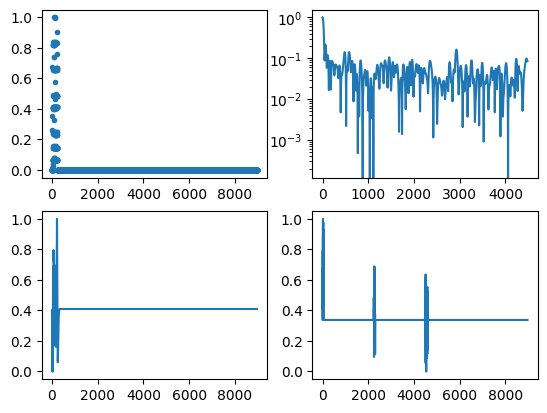

In [297]:
from numba import njit, jit
import pywt
from scipy.fft import fft, fftfreq
from scipy import signal

#@jit()# @jit(nopython=True, parallel=True)
def normalize(arrin, t_min, t_max):
    arr = np.array(arrin,dtype=np.float32)
    try:
        X_std = (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) - 1.
    except ZeroDivisionError:
        print('div by 0')
        X_std = (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) - 1.
    norm_arr = X_std * ((t_max - (t_min))+0.001) + t_max
    return norm_arr

# @jit(nopython=True, parallel=True)
# def norm_2d(x):
#     xmax = np.max(x)
#     return np.linalg.norm(x / xmax) * xmax

def norm_2d(sample_transformed):
    sample_transformed /= np.max(np.abs(sample_transformed),axis=0)
    return sample_transformed


def flatten_list(l):
    return [item for sublist in l for item in sublist]
#choosen_sample = np.delete(train[200][0],[0])
choosen_sample =train[2][0] # orginal signal
sample_transformed = choosen_sample
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
N = len(choosen_sample)
T = 1.0 / len(choosen_sample)
sample_transformed /= np.max(np.abs(sample_transformed),axis=0)
ax1.plot(sample_transformed,'.')
yfreq = fft(choosen_sample) # Fourier transform
xfreq = fftfreq(N, T)[:N//2]
ax2.semilogy(xfreq, normalize(2.0/N * np.abs(yfreq[0:N//2]),0,1))
widths = np.arange(1, 31)
wavelet = signal.ricker # only option unfortunately
#cwtmatr = signal.cwt(choosen_sample , wavelet, widths) # Continuous Wavelet Transform
cwtmatr, freqs = pywt.cwt(choosen_sample, widths, 'mexh') # Continuous Wavelet Transform # 'gaus1'
print(cwtmatr.shape)
coeffArray = pywt.wavedec(choosen_sample,'db1',level=2)  # Multilevel discrete Wavelet transform
#print(coeffArray)
# ax3.imshow(cwtmatr, extent=[-1, 1, 31, 1], cmap='seismic', aspect='auto',
#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
cwtmatr_sum = cwtmatr[0][:]
for i in range(1,len(cwtmatr)-1):
    cwtmatr_sum += cwtmatr[i][:]

ax3.plot(normalize(cwtmatr_sum,0,1))
print(cwtmatr_sum.shape)
dwt_coeffs = flatten_list(coeffArray)
ax4.plot(normalize(dwt_coeffs,0,1))


plt.show()

In [299]:
fft_train = []
fft_test_no_target = []
cwt_train = []
cwt_test_no_target = []
dwt_train = []
dwt_test_no_target = []
cwtwavelet = 'mexh'
dwtwavelet = 'db1'
w2_wavelet = 31
level = 2
widths = np.arange(1, w2_wavelet) # can be changed to optimize learning
for i in range(0,len(train)):
    choosen_sample =train[i][0]
    yfreq = fft(choosen_sample)
    N = 20000
    T = 1.0 / len(choosen_sample)
    fft_train.append(2.0/N * np.abs(yfreq[0:N//2]))
    cwtmatr, freqs = pywt.cwt(choosen_sample, widths,cwtwavelet)
    cwt_train.append(cwtmatr)
    coeffArray = pywt.wavedec(choosen_sample,dwtwavelet,level=level)
    dwt_coeffs = flatten_list(coeffArray)
    dwt_train.append(dwt_coeffs)
    print(i)

print(len(fft_train[0]),len(train[0][0]),len(cwt_train[:][0]),len(dwt_train[0]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
for i in range(0,len(test_no_target)):
    choosen_sample =test_no_target[i]
    yfreq = fft(choosen_sample)
    N = 20000
    T = 1.0 / len(choosen_sample)
    fft_test_no_target.append(2.0/N * np.abs(yfreq[0:N//2]))
    cwtmatr, freqs = pywt.cwt(choosen_sample, widths,cwtwavelet)
    cwt_test_no_target.append(cwtmatr)
    coeffArray = pywt.wavedec(choosen_sample,dwtwavelet,level=level)
    dwt_coeffs = flatten_list(coeffArray)
    dwt_test_no_target.append(dwt_coeffs)

In [300]:
print(len(test_no_target))                  # 1103 wierszy
for i in range(0, 1100, 100):
    print(type(test_no_target[i]))
    print(test_no_target[i])

1103
<class 'tuple'>
(0.0, 0.0, 0.0, 0.0, 88.0, 88.0, 88.0, 88.0, 69.0, 145.0, 145.0, 145.0, 5.0, 5.0, 5.0, 5.0, 92.0, 88.0, 88.0, 80.0, 45.0, 39.0, 190.0, 190.0, 124.0, 112.0, 112.0, 112.0, 77.0, 36.0, 36.0, 36.0, 20.0, 20.0, 13.0, 158.0, 127.0, 55.0, 55.0, 113.0, 127.0, 151.0, 22.0, 116.0, 144.0, 144.0, 34.0, 68.0, 33.0, 33.0, 33.0, 41.0, 41.0, 47.0, 47.0, 180.0, 12.0, 119.0, 37.0, 100.0, 112.0, 112.0, 2.0, 36.0, 0.0, 0.0, 0.0, 0.0, 88.0, 88.0, 120.0, 120.0, 12.0, 5.0, 13.0, 13.0, 92.0, 149.0, 32.0, 4.0, 12.0, 37.0, 12.0, 159.0, 13.0, 6.0, 124.0, 37.0, 124.0, 37.0, 37.0, 8.0, 8.0, 119.0, 78.0, 73.0, 12.0, 0.0, 0.0, 0.0, 88.0, 88.0, 88.0, 88.0, 69.0, 145.0, 145.0, 145.0, 5.0, 5.0, 5.0, 5.0, 92.0, 88.0, 88.0, 80.0, 45.0, 39.0, 190.0, 190.0, 124.0, 112.0, 112.0, 112.0, 77.0, 36.0, 36.0, 36.0, 20.0, 20.0, 13.0, 158.0, 127.0, 55.0, 55.0, 113.0, 127.0, 151.0, 22.0, 116.0, 144.0, 144.0, 34.0, 68.0, 33.0, 33.0, 33.0, 41.0, 41.0, 47.0, 47.0, 180.0, 12.0, 119.0, 37.0, 100.0, 112.0, 112.0, 2.0,

In [317]:
#np.seterr(divide='ignore', invalid='ignore')

data = [0. for _ in range(len(train))]
data_fft = [0. for _ in range(len(fft_train))]
data_targets = [0. for _ in range(len(train))]
data_cwt_sum = [0. for _ in range(len(train))]

# print(np.array(np.sum(cwt_train[0][:],axis=0)).shape)
for i in range(len(train)):
    data[i] = np.array(train[i][0],dtype=np.float32)
    data_fft[i] = np.array(fft_train[i],dtype=np.float32)
    dwt_train[i] = np.array(dwt_train[i],dtype=np.float32)
    data_cwt_sum[i] = np.array(np.sum(cwt_train[i][:],axis=0),dtype=np.float32)
    data_targets[i] = np.array(train[i][1],dtype=np.float32)

values, counts = np.unique(np.array(data_targets), return_counts=True)
#
# #print(data[0],data_fft[0].real,data_fft[0].imag,"\n",counts)
#

train_data_set = []

for i in range(0,len(data)):
    # print(data[i].shape,data_fft[i].real.shape,data_fft[i].imag.shape,data_cwt_sum[i].shape,dwt_train[i][0:-1].shape)
    train_data_set.append(np.array((data[i],data_fft[i].real,data_fft[i].imag,cwt_train[i][0],cwt_train[i][15],cwt_train[i][29],dwt_train[i][0:-1]),dtype=np.float32))


#data_cwt_sum[i] # probably could be better after normalization of some kind

In [318]:
torch.manual_seed(2022)

train_data = torch.FloatTensor(np.array(train_data_set))
train_targets = torch.FloatTensor(np.array(data_targets))
test_indices = torch.randperm(len(train_data))[:int(len(train_data)*0.2)]
sorted, indices_sorted = torch.sort(test_indices )
train_indecies = []

m = 0
for i in range(0,len(train_data)-2):
    index = int(np.array(sorted[m]))
    if  index == i:
        m+=1
    else:
        train_indecies.append(i)



test_data = train_data[test_indices]
test_targets = train_targets[test_indices]
ttrain_data = train_data[train_indecies]
ttrain_targets = train_targets[train_indecies]

In [319]:
train_set = torch.utils.data.TensorDataset(ttrain_data, ttrain_targets)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)   #
test_set = torch.utils.data.TensorDataset(test_data, test_targets)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [353]:
import torch.nn.functional as F

class RecurentClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size,bidirectional = True):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_size = input_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        # self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
        self.conv0 = nn.Conv2d(in_channels=7, out_channels=32, kernel_size=(3,3),padding=1)
        #self.norm0 = torch.nn.LayerNorm(16, elementwise_affine=True)
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1,1))
        #self.conv2 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=(1,1))
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers,bidirectional = bidirectional, dropout=0.3, batch_first=False)
        self.fc0 = nn.Linear(hidden_size*self.bidirectional, hidden_size*self.bidirectional)
        self.fc1 = nn.Linear(hidden_size*self.bidirectional, out_size)

        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=np.sqrt(6)/np.sqrt(self.input_size))
            if module.bias is not None:
                module.bias.data.zero_()


    def init_hidden(self, batch_size):
        h_t = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size,dtype=torch.float32)
        c_t = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size,dtype=torch.float32)
        return h_t, c_t

    def forward(self, x, h_t,c_t):
        #print("1:",x.size())
        #x= F.normalize(x,dim=3)
        x = F.relu(self.conv0(x))
        x = F.dropout(F.relu(self.conv1(x)),p=0.3)
        #x = F.relu(self.conv2(x))
        #x = F.relu(self.bnorm0(x))
        #\print("2:",x.size())
        # x = x.squeeze(1)
        x = x.squeeze(2)
        #print("3:",x.size())
        x = torch.transpose(x,2,1)
        #print("4:",x.size())
        x = torch.transpose(x,0,1)
        #print("5:",x.size())
        h_t,c_t = self.lstm(x, (h_t,c_t))
        #print("6:",x.size())
        #print("h1:",h_t.size())
        x = torch.transpose(h_t,0,1)
        #print("7:",x.size())
        x = x[:,-1]
        #print("8:",x.size())
        x = self.fc0(x)
        #print("9:",x.size())
        x = self.fc1(x)
        #print("10:",x.size())
        return x, (h_t,c_t)

model = RecurentClassifier(16,75,2,out_size=5).to(device)

# LOAD WHOLE MODEL
#PATH = "entire_model.pt"
# model = torch.load(PATH)
print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)
torch.cuda.empty_cache()

RecurentClassifier(
  (conv0): Conv2d(7, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lstm): LSTM(32, 75, num_layers=2, dropout=0.3, bidirectional=True)
  (fc0): Linear(in_features=150, out_features=150, bias=True)
  (fc1): Linear(in_features=150, out_features=5, bias=True)
)
236301


In [308]:
@torch.no_grad()
def eval_test(model,loader):
    total, correct = 0., 0.
    model.eval()
    for x, targets in loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        #targets = targets.view(len(targets), 5).long()
        h_t, c_t = model.init_hidden(x.size(0))
        h_t, c_t = h_t.to(device), c_t.to(device)
        preds, _ = model(x, h_t, c_t)
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets.long())
        with torch.no_grad():
            _, predicted_class = torch.max(preds, 1)
            total += targets.size(0)
            correct += (predicted_class == targets).sum().item()
    acc = correct / total
    return loss, acc

In [ ]:
from torch import optim

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_fun = nn.CrossEntropyLoss()
# Training loop

k = 0
train_loss_list = []
ttrain_acc = []
test_loss_list = []
ttest_acc = []
iter_list = []
PATH = "entire_model5.pt"

for epoch in range(20):
    total, correct = 0., 0.
    for x, targets in train_loader:
        model.train()
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        #targets = targets.view(len(targets), 5).long()
        h_t, c_t = model.init_hidden(x.size(0))
        h_t, c_t = h_t.to(device), c_t.to(device)
        preds, _ = model(x, h_t, c_t)
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets.long())
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            _, predicted_class = torch.max(preds, 1)
            total += targets.size(0)
            correct += (predicted_class == targets).sum().item()
    tloss,tacc = eval_test(model,test_loader)


    #scheduler.step()
    train_loss_list.append(loss.item())
    test_loss_list.append(tloss.item())
    iter_list.append(k)
    k +=1
    train_acc = correct / total
    ttrain_acc.append(train_acc)
    ttest_acc.append(tacc)
    #if epoch % 10 == 0:
    print(f"Epoch: {epoch}, loss: {loss.item():.3},test_loss: {tloss.item():.3}")
    print(f"Training accuracy {train_acc:.5%}, test_accuracy {tacc:.5%}")
    if epoch > 1:
        if ttrain_acc[epoch-1] < ttrain_acc[epoch] and ttest_acc[epoch-1] < ttest_acc[epoch]:
            torch.save(model, PATH)

plt.plot(iter_list,train_loss_list)
plt.plot(iter_list,test_loss_list)
plt.grid()
plt.show()
torch.cuda.empty_cache()

Epoch: 0, loss: 1.44,test_loss: 1.48
Training accuracy 34.27107%, test_accuracy 38.15000%
Epoch: 1, loss: 1.35,test_loss: 1.7
Training accuracy 40.26007%, test_accuracy 45.80000%
Epoch: 2, loss: 1.32,test_loss: 1.44
Training accuracy 44.38610%, test_accuracy 50.95000%
Epoch: 3, loss: 1.14,test_loss: 1.29
Training accuracy 47.89947%, test_accuracy 51.80000%
Epoch: 4, loss: 1.22,test_loss: 1.19
Training accuracy 49.04976%, test_accuracy 50.20000%
Epoch: 5, loss: 1.22,test_loss: 1.42
Training accuracy 47.49937%, test_accuracy 44.65000%
Epoch: 6, loss: 1.09,test_loss: 1.37
Training accuracy 44.49862%, test_accuracy 46.05000%
Epoch: 7, loss: 1.24,test_loss: 1.3
Training accuracy 47.01175%, test_accuracy 51.55000%


In [ ]:
with torch.no_grad():
      #for test in test_loader:
      hidden = model.init_hidden(test_data.size(0)).to(device)
      test_preds, _ = model(test_data.to(device).unsqueeze(2),hidden)
      print(test_preds == test_targets[0])
      #print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean())

In [ ]:
with torch.no_grad():
      #for test in test_loader:
      for i in range(len(train_data)):
          hidden = model.init_hidden(test_data.size(0)).to(device)
          test_preds, t_targets = model(test_data.to(device).unsqueeze(2),hidden)
          print(test_preds)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
labels_pred = []
total_eval_accuracy = 0

with torch.no_grad():
    model.eval()
    hidden = model.init_hidden(test_data.size(0)).to(device)
    preds, last_hidden = model(test_data.unsqueeze(2).to(device), hidden)
    preds = preds.squeeze(1)

    preds = preds.detach().cpu().numpy()
    label_ids = train_targets.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
    total_eval_accuracy += flat_accuracy(preds, label_ids)
    print(total_eval_accuracy)


df_results = pd.DataFrame({
    "labels_pred": labels_pred})
df_results.to_csv("df_results.csv")

In [ ]:
from IPython.core.display_functions import display
from collections import defaultdict
d = defaultdict(list)
results = []
excepts = 0
all = 0
model.eval()
class_d = {}

for x in test_loader:    
    all += 1
    try:

        #x = x.to(device).unsqueeze(2)
        hidden = model.init_hidden(x.size(0)).to(device)
        preds, last_hidden = model(x.unsqueeze(2).to(device), hidden)
        preds = preds.squeeze(1)
        preds = preds.cpu()
        result = preds.numpy()[0]
        print(result)
        results.append(result)
        d["result"].append(result)
        if result not in class_d.keys():
            class_d[result] = []
    except:
        excepts += 1

df = pd.DataFrame.from_dict(d)
df.to_csv("Glaza_Mikolajczyk.csv", header=False, index=False)
display(df.head())
plt.plot(results)
print(excepts, all)
print(results)

ZAPIS DO PLIKU CSV WYNIKÓW

In [ ]:
labels_pred = []
labels_prob_pred = []

for data_inputs, data_labels in iter(test_data_loader):
  model.eval()
  output = model(data_inputs.to(device).float())
  condition = output > 0.5
  output_list = condition.float().tolist()
  output_list = [item[0] for item in output_list]
  for item in output_list:
    labels_pred.append(item)
  for item in output.float().tolist():
    labels_prob_pred.append(item[0])

df_results = pd.DataFrame({
    "labels_pred": labels_pred,
    "labels_prob_pred": labels_prob_pred })
df_results.to_csv("df_results.csv")

In [ ]:
df_results.head()